In [252]:
import pandas as pd
import geopandas as gpd
from pyproj import CRS
import folium
from shapely.geometry import Point, Polygon
from geopandas.tools import geocode
import numpy as np

# Population data from "https://hri.fi/data/fi/dataset/vaestotietoruudukko" (2021.shp)

fp = 'Vaesto/Vaestotietoruudukko_2021.shp'
data = gpd.read_file(fp)
data = gpd.GeoDataFrame(data)

In [253]:
data = data.to_crs(4326)

In [254]:
# Post number data downloaded from https://hri.fi/data/fi/dataset/paakaupunkiseudun-postinumeroalueet
fp2 = 'PKS_postinumeroalueet_manner_2022/PKS_postinumeroalueet_2022_manner_shp.shp'
pn = gpd.read_file(fp2)
type(pn)

geopandas.geodataframe.GeoDataFrame

In [255]:
pop = data[['INDEX','ASUKKAITA','geometry']]
pop = pop.rename(columns={'ASUKKAITA' : 'pop2021'})

In [256]:
# Creating a buffer zone same size as the grid width to make sure each grid gets joined into the postal areas later on
pn['buffer'] = pn.buffer(250)
pn['geom_copy'] = pn['geometry']

In [257]:
# setting the buffer as temporary geometry
pn['geometry'] = pn['buffer']

In [258]:
# Creating a spatial join from population grid and postal areas.
pn = pn.to_crs(4326)
join_pop = gpd.sjoin(pop,pn, how= "inner", predicate="within")
join_pop['pop2021'].sum()

1395350

In [259]:
join_pop = join_pop[['INDEX','pop2021','geometry','Posno','Nimi','geom_copy']]

In [260]:
# grouping the data
gjp = join_pop.groupby('Posno')

In [261]:
# calculating the population in each area and saving the post number "Posno" for merging
total_pop = 0
pops = []
pop = pd.DataFrame()
pop['Posno'] = None
pop['Name'] = None
pop['pop_2021'] = None
for key,group in gjp:
    for row in group['pop2021']:
        total_pop = total_pop + row
    pop.loc[key, 'Posno'] = key
    pop.loc[key, 'pop_2021'] = total_pop
    total_pop = 0
pop

,Posno,Name,pop_2021
00100,00100,NaN,20781
00120,00120,NaN,12414
00130,00130,NaN,4378
00140,00140,NaN,9602
00150,00150,NaN,13528
...,...,...,...
02920,02920,NaN,6349
02940,02940,NaN,11609
02970,02970,NaN,3713
02980,02980,NaN,164


In [262]:
# Joining the population to the postal numbers and selecting desired columns. Renaming the columns after.
pop_join = pn.merge(pop,on='Posno')
pop_join = pop_join[['Posno','Nimi','geometry','pop_2021','geom_copy']]
pop_join = pop_join.rename(columns={'Nimi' : 'Name', 'Posno' : 'Post_num'})
pop_join

,Post_num,Name,geometry,pop_2021,geom_copy
0,00140,Kaivopuisto - Ullanlinna,"POLYGON ((24.93845 60.15895, 24.93844 60.15903...",9602,"MULTIPOLYGON (((25498208.112 6670802.701, 2549..."
1,00130,Kaartinkaupunki,"POLYGON ((24.93931 60.16563, 24.93829 60.16632...",4378,"POLYGON ((25497686.742 6672111.926, 25497576.3..."
2,02710,Viherlaakso,"POLYGON ((24.71320 60.22265, 24.71316 60.22265...",8539,"MULTIPOLYGON (((25485684.518 6677847.626, 2548..."
3,01530,Veromiehenkylä,"POLYGON ((24.90664 60.32477, 24.90671 60.32498...",649,"POLYGON ((25499852.283 6689008.790, 25499856.0..."
4,00860,Santahamina,"MULTIPOLYGON (((24.99017 60.13727, 24.99006 60...",309,"MULTIPOLYGON (((25505359.189 6670849.421, 2550..."
...,...,...,...,...,...
165,02360,Soukka,"MULTIPOLYGON (((24.64800 60.13773, 24.64805 60...",10442,"MULTIPOLYGON (((25481441.545 6666967.458, 2548..."
166,00620,Metsälä-Etelä-Oulunkylä,"POLYGON ((24.90952 60.21873, 24.90688 60.22192...",5411,"POLYGON ((25495215.752 6678541.062, 25495069.8..."
167,01720,Petikko,"POLYGON ((24.79899 60.27663, 24.79841 60.27710...",267,"POLYGON ((25489195.411 6684546.903, 25489178.4..."
168,02210,Olari,"POLYGON ((24.69234 60.17391, 24.69201 60.17409...",13167,"POLYGON ((25483509.598 6674281.435, 25483551.7..."


In [263]:
# Returning the unbuffered geometries, calculating areas and population density per km^2
pop_join['geometry'] = pop_join['geom_copy']
pop_join['area'] = pop_join['geometry'].area
pop_join['pop_den'] = pop_join['pop_2021'] / pop_join['area'] *1000000

# Rounding up the values, could round up even more roughly.
pop_join['pop_den'] = pop_join['pop_den'].apply(np.floor)
pop_join['area'] = pop_join['area'].apply(np.floor)
pop_join = pop_join[['Post_num','Name','geometry','pop_2021','area','pop_den']]
pop_join

,Post_num,Name,geometry,pop_2021,area,pop_den
0,00140,Kaivopuisto - Ullanlinna,"MULTIPOLYGON (((25498208.112 6670802.701, 2549...",9602,931620.0,10306
1,00130,Kaartinkaupunki,"POLYGON ((25497686.742 6672111.926, 25497576.3...",4378,447241.0,9788
2,02710,Viherlaakso,"MULTIPOLYGON (((25485684.518 6677847.626, 2548...",8539,2584209.0,3304
3,01530,Veromiehenkylä,"POLYGON ((25499852.283 6689008.790, 25499856.0...",649,18717264.0,34
4,00860,Santahamina,"MULTIPOLYGON (((25505359.189 6670849.421, 2550...",309,5650237.0,54
...,...,...,...,...,...,...
165,02360,Soukka,"MULTIPOLYGON (((25481441.545 6666967.458, 2548...",10442,4265200.0,2448
166,00620,Metsälä-Etelä-Oulunkylä,"POLYGON ((25495215.752 6678541.062, 25495069.8...",5411,1787828.0,3026
167,01720,Petikko,"POLYGON ((25489195.411 6684546.903, 25489178.4...",267,4974143.0,53
168,02210,Olari,"POLYGON ((25483509.598 6674281.435, 25483551.7...",13167,3681141.0,3576


<AxesSubplot:>

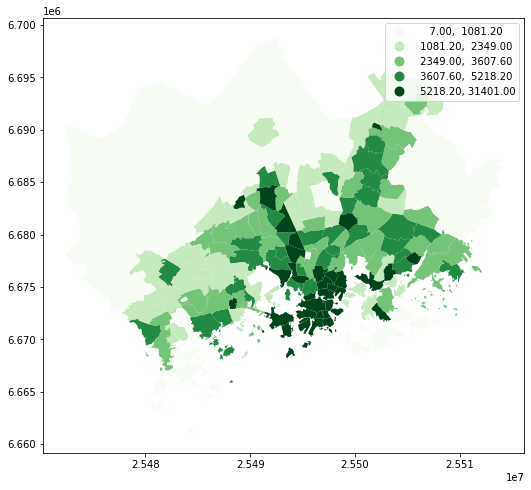

In [264]:
# quick data visualization
fig, ax = plt.subplots(figsize=(12,8))
pop_join.plot(ax=ax, column='pop_den', cmap='Greens', scheme='quantiles', legend=True)

In [265]:
# Creating index for folium plottin.
pop_join['geoid'] = pop_join.index.astype(str)

In [163]:
# Practised making GeoJson
#import pandas as pd, requests, json
#json1 = pop_join.to_json()
# gjson = folium.features.GeoJson(pop_join, name="Postal_areas")

In [269]:
# Using the same functions as in the instructions with my own variables.
import branca

# Create a series (or a dictionary?) out of the variable that you want to map
series = pop_join.set_index('Post_num')['pop_den']

# Setl colorscale
colorscale = branca.colormap.linear.Reds_05.to_step(data = pop_join['pop_den'], n = 5, method = 'quantiles')


            
def my_color_function(feature):
    
   population_density = series.get(int(feature['id']), None)

   return {
       'fillOpacity': 0.5,
       'weight': 0,
       'fillColor': '#black' if population_density is None else colorscale(population_density)
       }

#Define style function
folium.features.GeoJson(pop_join, name='Labels',
               style_function=lambda x: {'color':'transparent','fillColor':'transparent','weight':0},
                tooltip=folium.features.GeoJsonTooltip(fields=['pop_den'],
                                              aliases = ['Population density'],
                                              labels=True,
                                              sticky=False
                                             )
                       ).add_to(m)

In [273]:
# Folium basemap
m = folium.Map(location=[60.25, 24.8], tiles = 'cartodbpositron', zoom_start=10, control_scale=True)

# Plotting a choropleth map of population density and total population of an area. Select desired view from layer options.

folium.Choropleth(
    geo_data=pop_join,
    name='Population density in Helsinki region',
    data=pop_join,
    columns=['geoid', 'pop_den','pop_2021'],
    key_on='feature.id',
    fill_color='Reds',
    line_color='white', 
    line_weight=0,
    highlight=False, 
    smooth_factor=1.0,
    threshold_scale=[0,1000, 3000, 7500, 15000, 23000,33333],
    legend_name= 'Population density in Helsinki region (residents/km^2)').add_to(m)
#Define style function
folium.GeoJson(
   pop_join,
   name = "Population in Helsinki region",
   style_function=my_color_function,
   tooltip=folium.features.GeoJsonTooltip(fields=['pop_2021','Name','pop_den'],
                                             aliases = ['Residents', 'Postal area', 'Population density'],
                                             labels=True,
                                             sticky=True)
).add_to(m)

folium.LayerControl().add_to(m)
m
outfp='Exercise-5-master/Exercise-5-master/docs/Population_density_Helsinki.html'
m.save(outfp)

In [183]:
pop_join.head()

,Post_num,Name,geometry,pops_2021,area,pop_den,geoid
0,00140,Kaivopuisto - Ullanlinna,"MULTIPOLYGON (((25498208.112 6670802.701, 2549...",9602,9.316210e+05,10.306767,0
1,00130,Kaartinkaupunki,"POLYGON ((25497686.742 6672111.926, 25497576.3...",4378,4.472418e+05,9.788888,1
2,02710,Viherlaakso,"MULTIPOLYGON (((25485684.518 6677847.626, 2548...",8539,2.584210e+06,3.304298,2
3,01530,Veromiehenkylä,"POLYGON ((25499852.283 6689008.790, 25499856.0...",649,1.871726e+07,0.034674,3
4,00860,Santahamina,"MULTIPOLYGON (((25505359.189 6670849.421, 2550...",309,5.650238e+06,0.054688,4
